In [65]:
import pandas as pd
import statsmodels
from matplotlib import pyplot as plt
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from scipy.special import boxcox, inv_boxcox

from itertools import product
import statsmodels.api as sm

from pmdarima.arima import auto_arima

Обучите простую модель предсказания цены акций. Используйте рассмотренные на лекции алгоритмы предсказания рядов (не менее двух,например, модель Хольта-Уинтерса и SARIMA). Можно использовать и более сложные алгоритмы предсказания рядов


### 1. Найдите данные о цене любого биржевого актива

Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 
Найти данные можно на kaggle или использовать FAANG датасет из 1-й лабораторной.
Выбранный датасет - [Акции Тесла](https://www.kaggle.com/datasets/rpaguirre/tesla-stock-price)

In [66]:
dt_init = pd.read_csv('TeslaStocks.csv')

#### 2. Предобработайте данные

Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам.
Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы.

<AxesSubplot:>

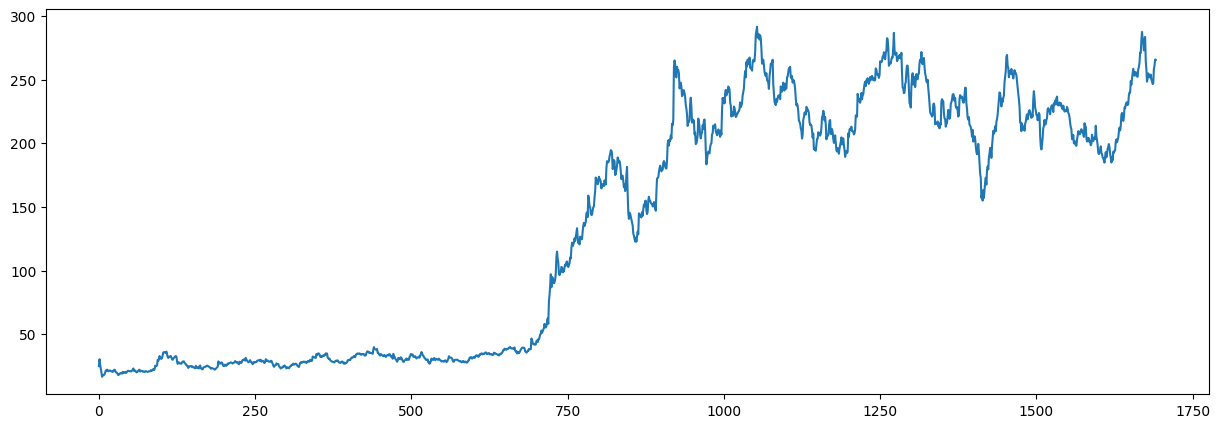

In [67]:
dt_init.Date = pd.to_datetime(dt_init.Date, errors='coerce')
dt_init.High = pd.to_numeric(dt_init.High, errors='coerce')

dt_init.High.plot(figsize=(15,5))

In [68]:
df = dt_init.resample('W', on='Date').mean()
print(df)

                  Open        High         Low       Close      Volume  \
Date                                                                     
2010-07-04   23.197500   26.110000   19.955000   22.220000  12328000.0   
2010-07-11   17.530000   18.012500   15.732500   16.692500   6387650.0   
2010-07-18   18.784001   19.932000   18.142000   19.111999   3087780.0   
2010-07-25   21.114000   21.562000   20.380000   20.944000   1435140.0   
2010-08-01   20.786000   20.980000   20.124000   20.502000    610400.0   
...                ...         ...         ...         ...         ...   
2017-02-19  274.633997  280.662006  271.641998  276.504010   6519200.0   
2017-02-26  268.105004  271.940002  263.092503  265.972508   9185850.0   
2017-03-05  249.398001  251.878000  246.457999  249.658002   5712100.0   
2017-03-12  248.134003  250.164001  245.430002  247.051999   3488820.0   
2017-03-19  254.866000  259.409998  252.666003  256.689996   5795820.0   

             Adj Close  
Date        

<AxesSubplot:title={'center':'Time series'}, xlabel='Date', ylabel='Price'>

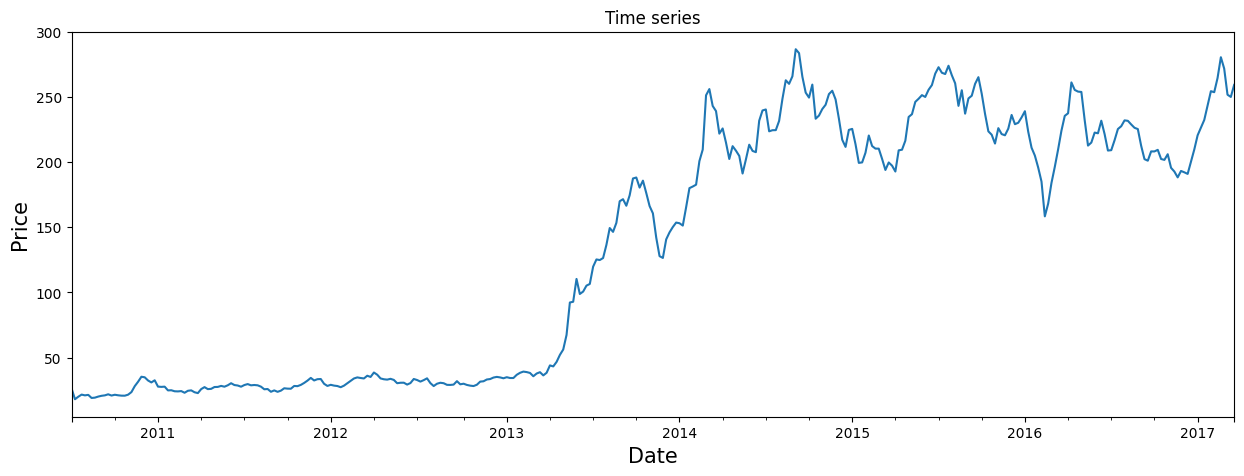

In [69]:
plt.figure(figsize=(15, 5))
plt.title('Time series')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', rotation=90, fontsize=15)
df.High.plot()

#### Разложим ряд на компоненты

1. Сам ряд
2. Тренд ряда
3. Сезонная компонента
4. Шум (непрогнозируемая ошибка)

<AxesSubplot:title={'center':'Residual'}, xlabel='Date'>

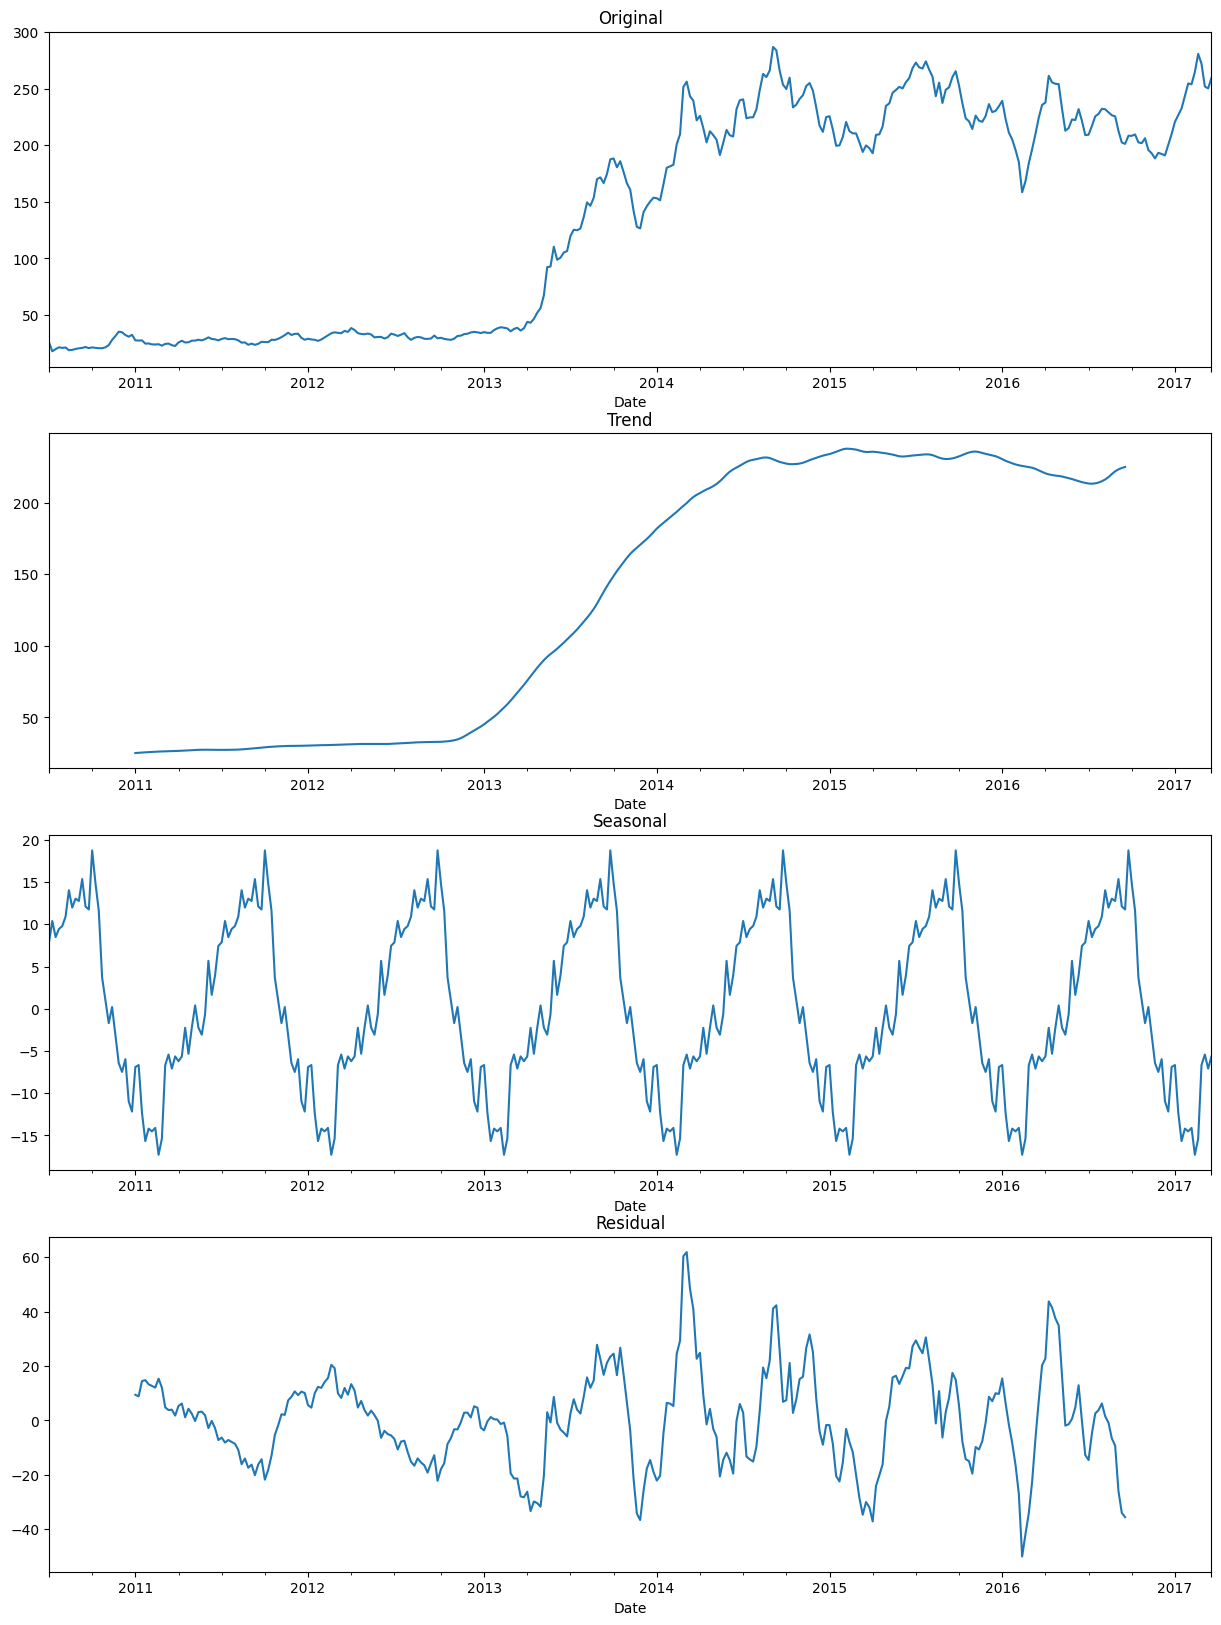

In [70]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))
decompose = seasonal_decompose(df[['High']], period=52)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3])

#### Прологарифмируем ряд

Логарифмирование помогает стабилизировать дисперсию, как можно увидеть на графике

<AxesSubplot:xlabel='Date'>

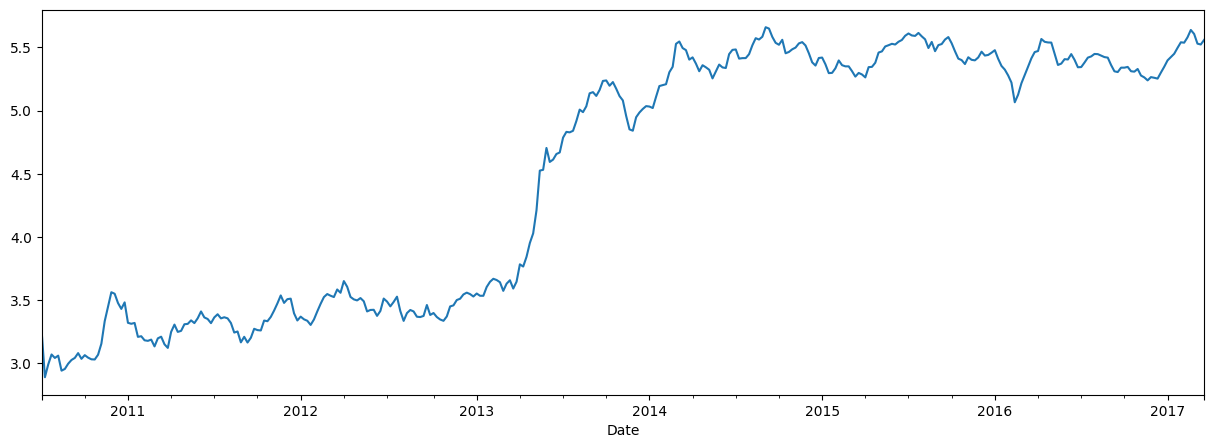

In [71]:
plt.figure(figsize=(15, 5))

df['HighLog'] = np.log(df['High'])
df['HighLog'].plot()

Но пока видно, что ряд нестационарный, так как тренд еще остался. Для стабилизации матожидания хорошо подходит дифференцирование (заменяем значение ряда на разность это значения и значения со сдвигом

<AxesSubplot:xlabel='Date'>

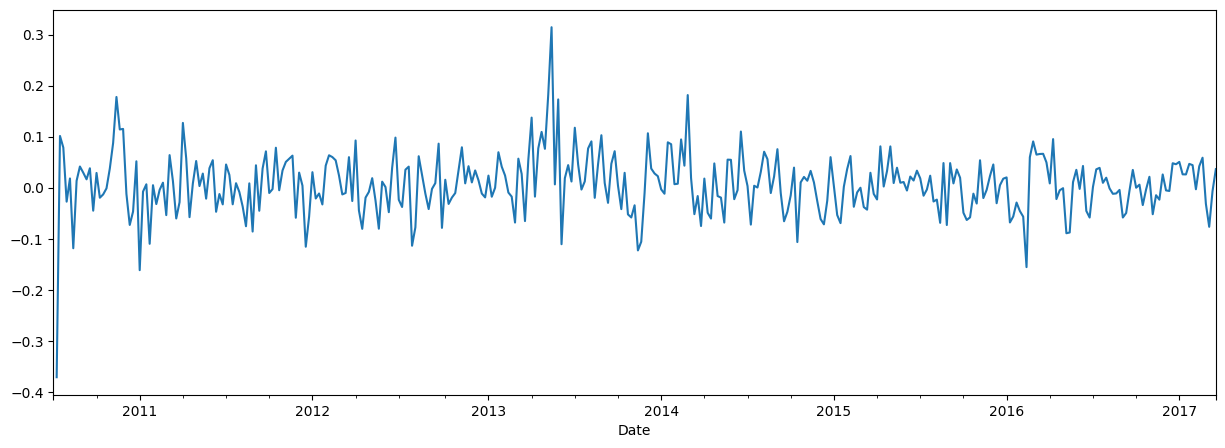

In [72]:
plt.figure(figsize = (15, 5))

df['HighLogDiff'] = df['HighLog'].diff(1)
df['HighLogDiff'].plot()

Проверим при помощи теста Дики-Фуллера, стационарен ли преобразованный ряд


In [73]:
test = adfuller(df["HighLogDiff"][1:])

print(df["HighLogDiff"])

adf = test[0]
p_value = test[1]
crit = test[4]

print(adf, p_value, crit)

if adf > crit['5%']:
    print('есть единичные корни, ряд не стационарный')
else:
    print('единичных корней нет, ряд стационарный')

Date
2010-07-04         NaN
2010-07-11   -0.371252
2010-07-18    0.101261
2010-07-25    0.078606
2010-08-01   -0.027363
                ...   
2017-02-19    0.058698
2017-02-26   -0.031570
2017-03-05   -0.076637
2017-03-12   -0.006828
2017-03-19    0.036293
Freq: W-SUN, Name: HighLogDiff, Length: 351, dtype: float64
-8.651968499419219 5.086689524361965e-14 {'1%': -3.449336554273722, '5%': -2.8699055166063085, '10%': -2.571226758215748}
единичных корней нет, ряд стационарный


/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


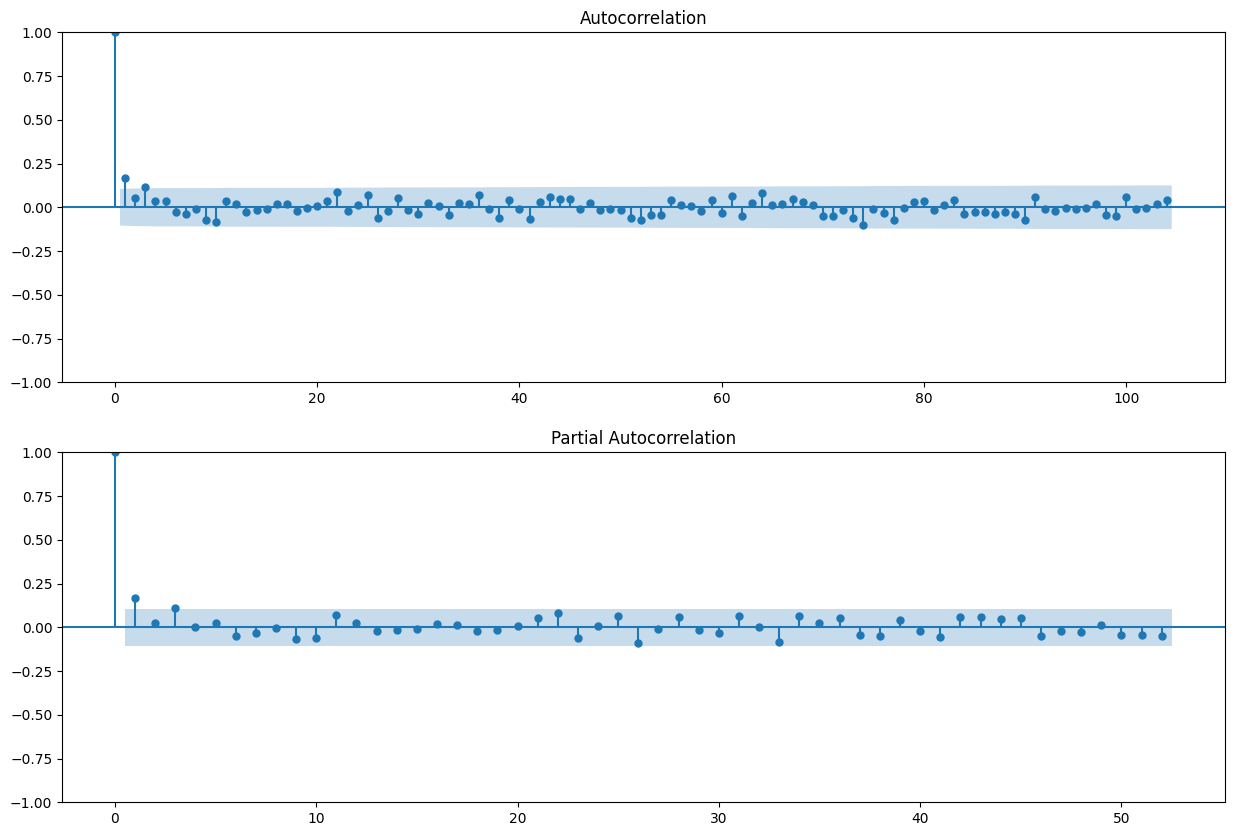

In [95]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
statsmodels.graphics.tsaplots.plot_acf(df['HighLogDiff'][1:], lags=104, ax=ax[0])
statsmodels.graphics.tsaplots.plot_pacf(df['HighLogDiff'][1:], lags=52, ax=ax[1])
plt.show()

279
71


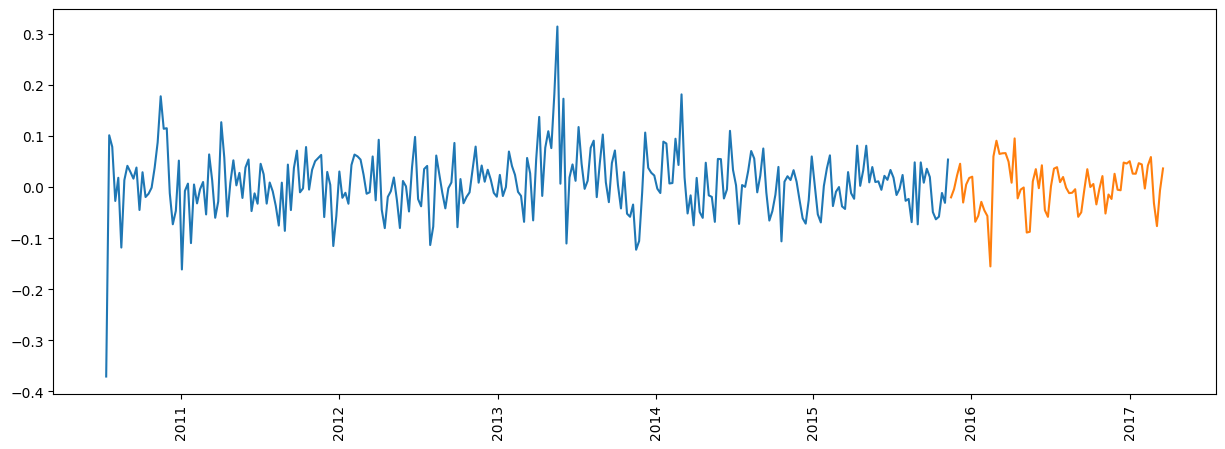

In [75]:
split_ind = int(len(df['HighLogDiff']) * 0.8)

train = df['HighLogDiff'][1 : split_ind]
test = df['HighLogDiff'][split_ind:]

print(len(train))
print(len(test))

plt.figure(figsize = (15, 5))
plt.xticks(rotation='vertical')
plt.plot(train)
plt.plot(test)
plt.show()

## SARIMAX

In [76]:
model = auto_arima(train, start_p=1, start_q=1, test='adf', max_p=1, max_q=1, m=52,
           start_P=1, max_P=1, max_Q=1, d=0, D=1, seasonal=True, error_action ='ignore', supress_warnings=True, trace=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=19.62 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=-439.892, Time=0.81 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=-506.907, Time=4.32 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=8.72 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=-441.875, Time=0.29 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=-446.026, Time=0.87 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=11.71 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=8.74 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=-504.248, Time=5.30 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=-506.936, Time=19.43 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=-446.191, Time=2.16 sec
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=11.57 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=-506.533, Time=12.66 sec
 ARIMA(1,0,1)(1,1,0)[52]             : AIC=-508.930, Time=7.77 sec
 ARIMA(1,0,1)(0,1,0)[52]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  279
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 52)   Log Likelihood                 258.465
Date:                             Tue, 25 Oct 2022   AIC                           -508.930
Time:                                     17:25:42   BIC                           -495.230
Sample:                                 07-11-2010   HQIC                          -503.401
                                      - 11-08-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7636      0.218      3.498      0.000       0.336       1.191
ma.L1         -0.6495      0.256     -2.533      0.011      -1.152      -0.147
ar.S.L52      -0.5421      0.047    -11.655      0.000      -0.633      -0.451
sigma2         0.0055      0.000     12.693      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                75.75
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.81
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
from sklearn.metrics import mean_absolute_percentage_error

fitted, confint = model.predict(n_periods=len(test), return_conf_int=True)

fitted = pd.Series(fitted)
print(fitted)
print(df['High'])

2015-11-15   -0.046603
2015-11-22   -0.048928
2015-11-29   -0.015051
2015-12-06    0.031858
2015-12-13   -0.010867
                ...   
2017-02-19    0.003740
2017-02-26    0.044977
2017-03-05   -0.023867
2017-03-12   -0.045206
2017-03-19    0.017863
Freq: W-SUN, Length: 71, dtype: float64
Date
2010-07-04     26.110000
2010-07-11     18.012500
2010-07-18     19.932000
2010-07-25     21.562000
2010-08-01     20.980000
                 ...    
2017-02-19    280.662006
2017-02-26    271.940002
2017-03-05    251.878000
2017-03-12    250.164001
2017-03-19    259.409998
Freq: W-SUN, Name: High, Length: 351, dtype: float64


2015-11-15    221.632001
2015-11-22    211.048996
2015-11-29    207.896253
2015-12-06    214.626045
2015-12-13    212.306268
                 ...    
2017-02-19    276.968641
2017-02-26    289.710392
2017-03-05    282.877657
2017-03-12    270.374702
2017-03-19    275.247788
Freq: W-SUN, Length: 71, dtype: float64


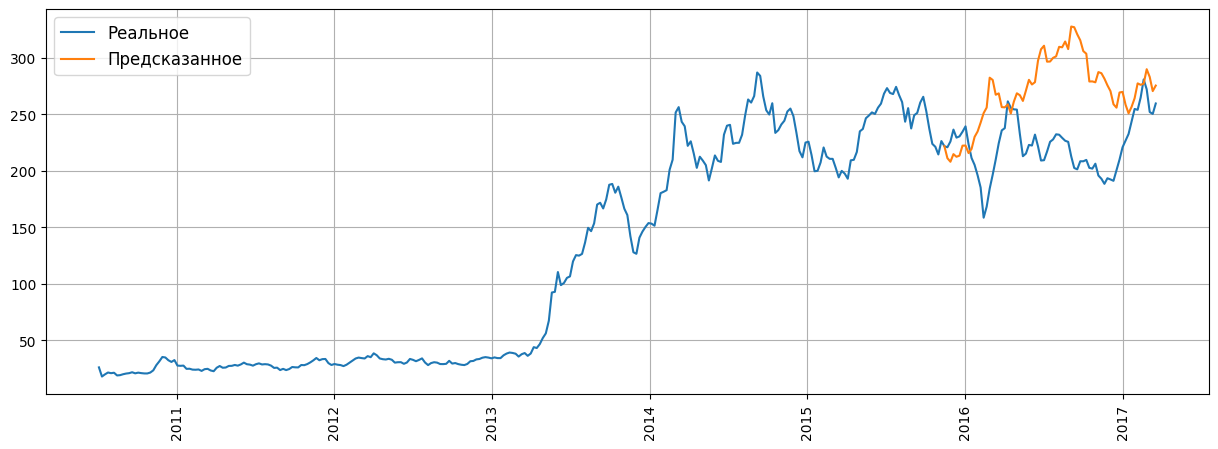

In [78]:
def undiff(orig, diffed):
    arr = diffed.copy()
    arr[0] = orig[0]
    return arr.cumsum()

predicted = undiff(df['HighLog'][split_ind:], fitted).apply(lambda x: np.exp(x))

print(predicted)

plt.figure(figsize=(15, 5))
plt.plot(df['High'], label = "Реальное")
plt.plot(predicted, label = "Предсказанное")
plt.grid(True)
plt.xticks(rotation='vertical')
plt.legend(fontsize=12)
plt.show()

In [79]:
mean_absolute_percentage_error(df['High'][split_ind:], predicted)


0.25134188207569136

## Модель Хольта-Уинтерса

In [80]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

2015-11-15    225.269520
2015-11-22    223.588230
2015-11-29    222.158729
2015-12-06    221.792264
2015-12-13    218.691003
                 ...    
2017-02-19    269.437346
2017-02-26    277.475760
2017-03-05    277.252767
2017-03-12    273.277136
2017-03-19    272.827864
Freq: W-SUN, Length: 71, dtype: float64


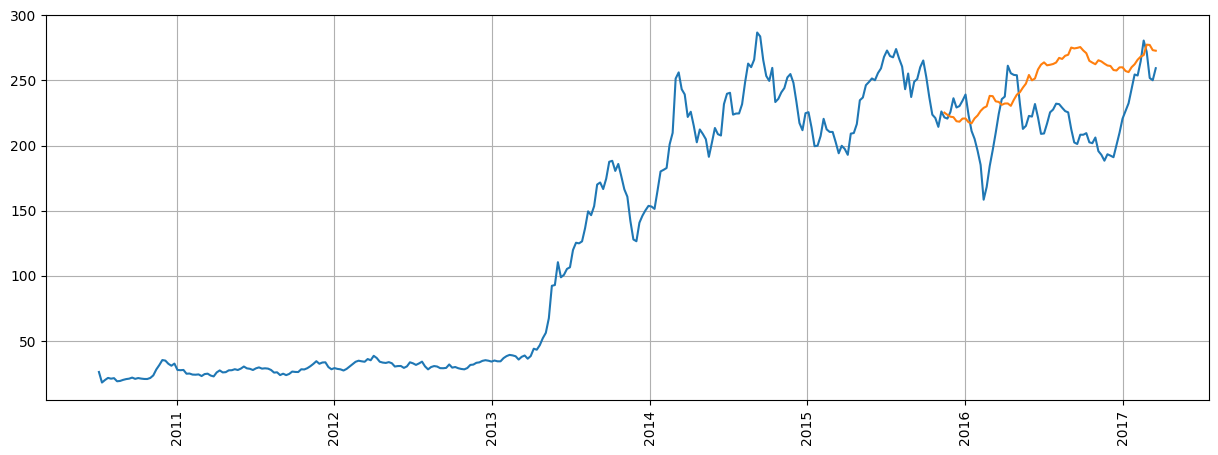

In [87]:
model = ExponentialSmoothing(df['High'][:split_ind], trend="add", seasonal="add", seasonal_periods=52)
fit = model.fit()
fitted = fit.forecast(len(test))

predicted = pd.Series(fitted)

print(predicted)

plt.figure(figsize=(15, 5))
plt.plot(df['High'])
plt.plot(predicted)
plt.xticks(rotation='vertical')
plt.grid(True)
plt.show()

In [88]:
mean_absolute_percentage_error(df['High'][split_ind:], predicted)

0.16682533473674496